# Example: Risk Assessment of Oregon Highway Network

__Note__: Parallel computing works only on Linux systems. In practice, it is recommended to run `OR_risk.py` script instead of this notebook file. This notebook is intended for the generation of network models and clarifies the steps in the `OR_risk.py` file.

In [35]:
import numpy as np
import osmnx as ox
import networkx as nx

from highway_network import generate_highway_graph
from highway_network import identify_end_nodes, generate_od_pairs
from highway_network import bridge_path_capacity

## Generate simplified network model

### Retrieve GIS data and generate raw graph

Using `OSMnx`, we can download and generate raw graph model based on

* Place filter: a string such as `"Oregon, USA"` or more precisely a dictionary such as `{'state': 'Oregon', 'country': 'USA'}`

* Link filter: for highways, we extract all line objects labled as "motorway", "trunk", and "primary" as defined in [OpenStreetMap](https://wiki.openstreetmap.org/wiki/Key:highway). This is achieved by the following string: `'["highway"~"motorway|trunk|primary"]'`

For large networks, the generation may take a while. Therefore, we can save the graph to local storage for future use. We store this network in `assets` subfolder in the project folder.

Unless a new network is needed, the following cells will load this saved network. Uncomment the first cell if you want to generate a new one.

In [ ]:
# # download/load and generate raw osmnx Graph
# place = {"state": "Oregon", "country": "USA"}
# filter = '["highway"~"motorway|trunk|primary"]'
# G_raw = ox.graph_from_place(place, truncate_by_edge=True, custom_filter=filter)

# # save the graph for future use
# ox.save_graphml(G_raw, filepath="./assets/or_hwy2prim_raw.gpkg")

# # save to a geopackage for GIS postprocessing
# ox.save_graph_geopackage(G_raw, filepath="./assets/or_hwy2prim_raw.gpkg")

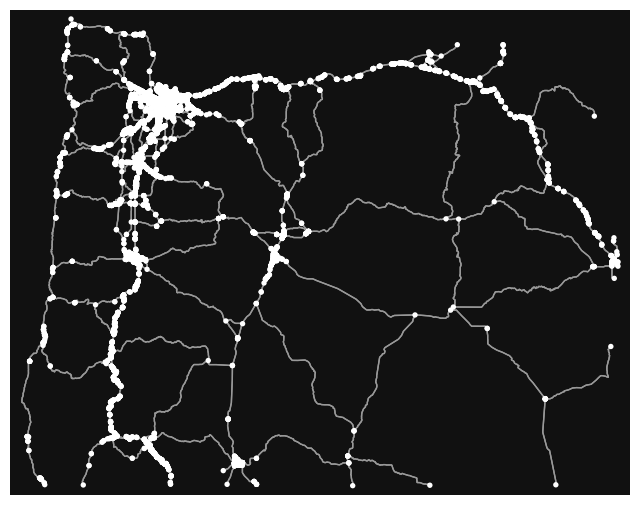

In [2]:
# load previously generated graph model
G_raw = ox.load_graphml(filepath="./assets/or_hwy2prim_raw.graphml")

# plot the graph if wanted
fig, ax = ox.plot_graph(G_raw)

### Simplify the graph and return its computational core

The `generate_highway_graph` is used to simply the graph and to generate its computational core. Important parameters include:

* `consol_tolerance`: tolerance in map unit to conduct node consolidation. The map must be converted to a projected CRS (e.g., [EPSG:3857](https://epsg.io/3857)). In this case, the map unit is meter.

* `min_lane` and `max_speed`: the minimum lane width along a link and the maximum speed on that link, respectively. They are used to generate link capacities based on Equation 10 in the report.

For OR network, the computational graph has been provided directly in `asset` subfolder.

In [17]:
# generate new simplified GIS and computational graphs.
G_comp, G_gis = generate_highway_graph(
    G_raw, crs='epsg:3857', consol_tolerance=100,
    min_lane=2, max_speed=60)

# # save the graphs to avoid regeneration. Use nx implementation
# # for G_comp since it is not a MultiGraph and cause error when
# # using ox.save_graphml
# nx.write_graphml(G_comp, "./assets/or_comp_graph.graphml")

# # save G_gis as geopackage for GIS postprocessing
# ox.save_graph_geopackage(G_gis, filepath="./assets/or_simple_graph.gpkg")

# # TODO: allow load_graphml for G_gis saved by the following line
# ox.save_graphml(G_gis, filepath="./assets/or_simple_graph.graphml")

### Generate origin destination pairs

The OD pairs can be selected from all boundary nodes (`bnd_nodes`) or all end nodes (`end_nodes`). The former is used in the report to determine highway throughput.

To generate the OD pairs, a minimum distance between pairs of nodes can also be used as a selection criterion. This is achieved by `min_distance` argument of `generate_od_pairs` function.

In [32]:
bnd_nodes, end_nodes = identify_end_nodes(
    G_gis, state_polygon='./gis/OR-boundary/OR-boundary.shp')

bnd_od, shortest_path_log = generate_od_pairs(
    G_comp, end_nodes=bnd_nodes, min_distance=50e3)

# # save the OD pairs to assets
# np.savez('./assets/bnd_od.npz', bnd_od=bnd_od)

In [33]:
# # alternatively, all end nodes can be selected as OD
# end_od, shortest_path_log2 = generate_od_pairs(
#     G_comp, end_nodes=end_nodes, min_distance=50e3)
# np.savez('./assets/end_od.npz', end_od=end_od)

Once can also use the `shortest_path_log` data to generate bridge path capacity. This capacity is determined as follows:

* `shortest_path_log` contains the shortest OD-pair path using a bridge link.

* `bridge_path_capacity` then returns the maximum flow along that OD pair.

In [36]:
path_capacity = bridge_path_capacity(G_comp, shortest_path_log)

## Conduct risk assessment

One can run this following cells without the previous section by loading necessary graph models and OD information from previous calculcations. Therefore, new blocks of imports are added below.

In [23]:
import numpy as np
import networkx as nx
import multiprocess as mp
import time

from UQpy.sampling import MetropolisHastings
from UQpy.distributions import Normal, Uniform, MultivariateNormal

from parallel_tempMCMC import SequentialTemperingMCMCpar
from highway_risk_temper import scenario_logC
from highway_risk_temper import get_damage_state

In [24]:
G_comp = nx.read_graphml('./assets/or_comp_graph.graphml', node_type=int)
od_pairs = np.load('./assets/bnd_od.npz')['bnd_od']

### Set constants

In [25]:
remain_capacity = 1/60*20
min_beta, max_beta = 0, 3
mcmc_covar = 0.5**2
cov_threshold = 0.2
random_state = 42
damage_db = dict()

Two modes are available in `OR_risk.py`: `mode='run'` run risk assessment with full parallelization; `mode='test'` run a simply version with only five bridge links to make sure the code runs well.

In practice, it is recommended to run `OR_risk.py` script and set `mode='run'`.

Herein, `mode='test'` is used to clarify the steps in `OR_risk.py`.

In [26]:
mode = 'test'

n_jobs = 8
n_chains, resample_pct, n_smp = 10, 10, 100
n_burn, n_jump = 10, 1

n_br = 5
max_flow = 100.0    # assumed max_flow so all tested bridges will have a non-zeros cost

# test with the first 5 bridges
for u, v, b in G_comp.edges.data('bridge_id'):
    if b > n_br:
        G_comp[u][v]['bridge_id'] = 0
bridge_list = [b for _, _, b in G_comp.edges.data('bridge_id') if b>0]

### Generate asset reliability indicies

In [27]:
beta_array = Uniform(loc=min_beta, scale=max_beta-min_beta,).rvs(
    nsamples=n_br, random_state=1)
beta_array = beta_array.flatten()
pf_array = Normal().cdf(-beta_array)

### Setup and run TMCMC

In [28]:
# define intermediate function
def log_pdf_intermediate(
        x, b, beta_array=beta_array, from_condition=False,
        G=G_comp, od_pairs=od_pairs, remain_capacity=remain_capacity,
        capacity='capacity', max_flow=max_flow,
        damage_db=None,
        epsilon=1e-6,
    ):

    if b == 0:
        res = np.zeros(x.shape[0])
    else:
        logC, = scenario_logC(
            x, beta_array=beta_array, from_condition=from_condition, G=G,
            od_pairs=od_pairs, remain_capacity=remain_capacity,
            capacity=capacity, max_flow= max_flow,
            damage_db=damage_db, epsilon=epsilon,
        )

        res = b*logC

    return res

# define mcmc_sampler for new samples
mcmc_sampler = MetropolisHastings(
    dimension=n_br, n_chains=n_chains,
    proposal=MultivariateNormal(mean=[0.0]*n_br, cov=mcmc_covar),
    burn_length=n_burn, jump=n_jump,
)
prior = MultivariateNormal(mean=[0.0]*n_br, cov=1.0)

# parallel computing
with mp.Manager() as manager:
    mp_dict = manager.dict(damage_db)
    try:
        use_log_pdf = lambda x,b: log_pdf_intermediate(x,b, damage_db=mp_dict)
        prior_log_pdf = lambda x: prior.log_pdf(x)
        sampler = SequentialTemperingMCMCpar(
            log_pdf_intermediate=use_log_pdf,
            distribution_reference=prior,
            save_intermediate_samples=True,
            percentage_resampling=resample_pct,
            sampler=mcmc_sampler,
            weight_cov_threshold=cov_threshold,
            random_state=random_state,
            nsamples=n_smp, n_jobs=n_jobs,
        )
        time0 = time.time()
        sampler.parallel_run(
            nsamples=n_smp, n_jobs=n_jobs,
            log_pdf_intermediate=use_log_pdf,
            prior_log_pdf=prior_log_pdf,
        )
        time1 = time.time()
    except KeyboardInterrupt:
        pass
    damage_db.update(mp_dict)

Report results

In [29]:
samples = sampler.samples
damage_condition = get_damage_state(samples, beta_array).astype(int)
unique_condition, counts = np.unique(damage_condition, axis=0, return_counts=True)
evidence = sampler.evidence
print(f'Sampling completed in {time1-time0} seconds')
print(f'evidence estimated: {evidence}')

Sampling completed in 104.69602584838867 seconds
evidence estimated: [0.07879183]


## Python script for parallel computing

Run the `OR_risk.py` to fully leverage parallel computing capacity.